In [76]:
import numpy as np
import matplotlib.pyplot as plt
import MARIGOLD as mg
import os
import openpyxl as op

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [77]:
author = 'talley'
refetch = True
xl_compare = True
multiplot = True

# [-] Nondimensional, units in L/D ***If you're inputting in [m], convert to diameters
z_step = 0.01 / 0.0381

preset = 'talley'
debug = False

Talley's horizontal model uses:
- jg/vgz to calculate alpha
- Ishii Chawla to compute ur (no iteration)
- Contributions from VG, PD, TI, RC, WE
- DOE method for SEXP (SPD)
- Pre-calculates jg development based on pressure

Need to implement:
- OP_vel = 2: Talley horizontal DFM
- OP_press(?): horizontal LM? What we have right now might be sufficient
- OP_COV = 3: Void reconstruction COV model (MATLAB script has hard-coded COV values)

Definitely something wrong with pressure drop calculation

In [78]:
endpoints = [116, 244]
modes = [None, None]

In [79]:
database = None

if author == 'talley':
    cwd = os.path.abspath("H:\TRSL-H\IATE\Data\spreadsheets\\38.1mm_talley")
    # print(cwd)
    dat_to_fetch = 'database_t.dat'

    if refetch:
        mg.extractLocalDataFromDir(cwd, dump_file=dat_to_fetch, sheet_type='talley_template', debug=True)

if database == None:
    database = mg.loadProbeData(dat_to_fetch)

In [80]:
# # Unique flow condition finding, for plotting
# cmap = []
# lmap = []
# for i, cond in enumerate(database):
#     print(cond)
#     cmap.append([cond.theta, cond.jf, cond.jgref])
#     lmap.append(cond.LoverD)
# cmap = np.array(cmap)
# umap = np.unique(cmap,axis=0)
# sp = np.min(lmap)

# print(f"\nsp: {sp}")

jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley
jf=3.98_jgloc=0.10_theta=0.0_port=116D_Talley
jf=3.98_jgloc=0.11_theta=0.0_port=244D_Talley
jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley
jf=3.98_jgloc=0.17_theta=0.0_port=116D_Talley
jf=3.98_jgloc=0.19_theta=0.0_port=244D_Talley
jf=4.98_jgloc=0.08_theta=0.0_port=44D_Talley
jf=4.98_jgloc=0.09_theta=0.0_port=116D_Talley
jf=4.98_jgloc=0.10_theta=0.0_port=244D_Talley
jf=4.98_jgloc=0.13_theta=0.0_port=44D_Talley
jf=4.98_jgloc=0.14_theta=0.0_port=116D_Talley
jf=4.98_jgloc=0.17_theta=0.0_port=244D_Talley
jf=4.98_jgloc=0.26_theta=0.0_port=44D_Talley
jf=4.98_jgloc=0.28_theta=0.0_port=116D_Talley
jf=4.98_jgloc=0.33_theta=0.0_port=244D_Talley
jf=5.98_jgloc=0.07_theta=0.0_port=44D_Talley
jf=5.98_jgloc=0.07_theta=0.0_port=116D_Talley
jf=5.98_jgloc=0.09_theta=0.0_port=244D_Talley
jf=5.98_jgloc=0.11_theta=0.0_port=44D_Talley
jf=5.98_jgloc=0.12_theta=0.0_port=116D_Talley
jf=5.98_jgloc=0.15_theta=0.0_port=244D_Talley
jf=5.98_jgloc=0.22_theta=0.0_port=44D_Tal

Below is my first pass at implementing COV interpolation, like Talley used to get his COV values
Realized that Talley interpolates more than just COV. Decided to move the interpolation inside of IATE function instead

In [81]:
# COV_RC_port = np.zeros((9,3))
# COV_TI_port = np.zeros((9,3))

# for cond in database:
#     cond:mg.Condition

#     if True: # cond.LoverD == 44:
#         # print(cond)
#         cond.mirror(sym90=True)

#         if cond.LoverD == 44:
#             rf = False
#         else:
#             rf = True

#         if cond.jf == 3.98 and cond.jgatm == 0.15:
#             run_ID = 1
#         elif cond.jf == 3.98 and cond.jgref == 0.25:
#             run_ID = 2
#         elif cond.jf == 4.98 and cond.jgref == 0.15:
#             run_ID = 3
#         elif cond.jf == 4.98 and cond.jgref == 0.25:
#             run_ID = 4
#         elif cond.jf == 4.98 and cond.jgref == 0.50:
#             run_ID = 5
#         elif cond.jf == 5.98 and cond.jgref == 0.15:
#             run_ID = 6
#         elif cond.jf == 5.98 and cond.jgref == 0.25:
#             run_ID = 7
#         elif cond.jf == 5.98 and cond.jgref == 0.50:
#             run_ID = 8
#         elif cond.jf == 5.98 and cond.jgref == 1.00:
#             run_ID = 9

#         if cond.LoverD == 44:
#             port_ID = 1
#         elif cond.LoverD == 116:
#             port_ID = 2
#         elif cond.LoverD == 244:
#             port_ID = 3
        
#         COV_RC_port[run_ID-1][port_ID-1] = cond.calc_COV_RC(reconstruct_flag = rf)
#         COV_TI_port[run_ID-1][port_ID-1] = cond.calc_COV_TI(reconstruct_flag = rf)

#         # print(f"\tCOV_RC: {COV_RC:.3f}\tCOV_TI: {COV_TI:.3f}")

In [82]:
# z_mesh = np.arange(44, 244 + z_step, z_step)
# port_locs = [44, 116, 244]
# # z_mesh = z_mesh * cond.Dh
# # z_step = z_step * cond.Dh

# COV_RC = []
# COV_TI = []

# COV_RC_port = np.nan_to_num(COV_RC_port, nan=1.0)
# COV_TI_port = np.nan_to_num(COV_TI_port, nan=1.0)

# for i in range(9):
#     COV_RC.append(np.interp(z_mesh,port_locs,COV_RC_port[i]))
#     COV_TI.append(np.interp(z_mesh,port_locs,COV_TI_port[i]))

In [83]:
# Unique flow condition finding, for plotting and other hijinks
LoverDs = []
condor = [[0]*3 for _ in range(9)]

for cond in database:
    cond:mg.Condition

    LoverDs.append(cond.LoverD)

    if cond.jf == 3.98 and cond.jgref == 0.15:
        run_ID = 1
    elif cond.jf == 3.98 and cond.jgref == 0.25:
        run_ID = 2
    elif cond.jf == 4.98 and cond.jgref == 0.15:
        run_ID = 3
    elif cond.jf == 4.98 and cond.jgref == 0.25:
        run_ID = 4
    elif cond.jf == 4.98 and cond.jgref == 0.50:
        run_ID = 5
    elif cond.jf == 5.98 and cond.jgref == 0.15:
        run_ID = 6
    elif cond.jf == 5.98 and cond.jgref == 0.25:
        run_ID = 7
    elif cond.jf == 5.98 and cond.jgref == 0.50:
        run_ID = 8
    elif cond.jf == 5.98 and cond.jgref == 1.00:
        run_ID = 9

    if cond.LoverD == 44:
        port_ID = 1
    elif cond.LoverD == 116:
        port_ID = 2
    elif cond.LoverD == 244:
        port_ID = 3

    condor[run_ID-1][port_ID-1] = cond

sp = np.min(LoverDs)
print(f"\nsp: {sp}")

[[jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley, jf=3.98_jgloc=0.10_theta=0.0_port=116D_Talley, jf=3.98_jgloc=0.11_theta=0.0_port=244D_Talley], [jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley, jf=3.98_jgloc=0.17_theta=0.0_port=116D_Talley, jf=3.98_jgloc=0.19_theta=0.0_port=244D_Talley], [jf=4.98_jgloc=0.08_theta=0.0_port=44D_Talley, jf=4.98_jgloc=0.09_theta=0.0_port=116D_Talley, jf=4.98_jgloc=0.10_theta=0.0_port=244D_Talley], [jf=4.98_jgloc=0.13_theta=0.0_port=44D_Talley, jf=4.98_jgloc=0.14_theta=0.0_port=116D_Talley, jf=4.98_jgloc=0.17_theta=0.0_port=244D_Talley], [jf=4.98_jgloc=0.26_theta=0.0_port=44D_Talley, jf=4.98_jgloc=0.28_theta=0.0_port=116D_Talley, jf=4.98_jgloc=0.33_theta=0.0_port=244D_Talley], [jf=5.98_jgloc=0.07_theta=0.0_port=44D_Talley, jf=5.98_jgloc=0.07_theta=0.0_port=116D_Talley, jf=5.98_jgloc=0.09_theta=0.0_port=244D_Talley], [jf=5.98_jgloc=0.11_theta=0.0_port=44D_Talley, jf=5.98_jgloc=0.12_theta=0.0_port=116D_Talley, jf=5.98_jgloc=0.15_theta=0.0_port=244D_Talley], [jf=5

In [84]:
[row[0] for row in condor]

[jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley,
 jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley,
 jf=4.98_jgloc=0.08_theta=0.0_port=44D_Talley,
 jf=4.98_jgloc=0.13_theta=0.0_port=44D_Talley,
 jf=4.98_jgloc=0.26_theta=0.0_port=44D_Talley,
 jf=5.98_jgloc=0.07_theta=0.0_port=44D_Talley,
 jf=5.98_jgloc=0.11_theta=0.0_port=44D_Talley,
 jf=5.98_jgloc=0.22_theta=0.0_port=44D_Talley,
 jf=5.98_jgloc=0.43_theta=0.0_port=44D_Talley]

In [111]:
for i, row in enumerate([row for row in condor]):
    for ii, cond in enumerate([col for col in row]):
        print(row)
        print(cond)
        print(f"i: {i}\tii: {ii}")



[jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley, jf=3.98_jgloc=0.10_theta=0.0_port=116D_Talley, jf=3.98_jgloc=0.11_theta=0.0_port=244D_Talley]
jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley
i: 0	ii: 0
[jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley, jf=3.98_jgloc=0.10_theta=0.0_port=116D_Talley, jf=3.98_jgloc=0.11_theta=0.0_port=244D_Talley]
jf=3.98_jgloc=0.10_theta=0.0_port=116D_Talley
i: 0	ii: 1
[jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley, jf=3.98_jgloc=0.10_theta=0.0_port=116D_Talley, jf=3.98_jgloc=0.11_theta=0.0_port=244D_Talley]
jf=3.98_jgloc=0.11_theta=0.0_port=244D_Talley
i: 0	ii: 2
[jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley, jf=3.98_jgloc=0.17_theta=0.0_port=116D_Talley, jf=3.98_jgloc=0.19_theta=0.0_port=244D_Talley]
jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley
i: 1	ii: 0
[jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley, jf=3.98_jgloc=0.17_theta=0.0_port=116D_Talley, jf=3.98_jgloc=0.19_theta=0.0_port=244D_Talley]
jf=3.98_jgloc=0.17_theta=0.0_port=116D_Talley
i: 1	ii: 1
[jf=3.98_jgl

In [90]:
# passkey = 'cond.jf == 3.98 and cond.jgref == 0.15'
passkey = 'True'

jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley
	rho_m: 968.13	mu_m: 0.0010	v_m: 4.1111	Rem: 151642.3228	f_TP: 0.0161	eps: 14.7208	We_avg: 5.2680
	rho_m: 968.13	mu_m: 0.0010	v_m: 4.1111	Rem: 151642.3228	f_TP: 0.0161	eps: 14.7208	We_avg: 5.2680
jf=3.98_jgloc=0.09_theta=0.0_port=44D_Talley
	rho_m: 968.13	mu_m: 0.0010	v_m: 4.1111	Rem: 151642.3228	f_TP: 0.0161	eps: 14.7208	We_avg: 5.2680
	rho_m: 968.13	mu_m: 0.0010	v_m: 4.1111	Rem: 151642.3228	f_TP: 0.0161	eps: 14.7208	We_avg: 5.2680
jf=3.98_jgloc=0.10_theta=0.0_port=116D_Talley
jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley
	rho_m: 952.87	mu_m: 0.0010	v_m: 4.1770	Rem: 151645.2512	f_TP: 0.0162	eps: 15.5018	We_avg: 5.9204
	rho_m: 952.87	mu_m: 0.0010	v_m: 4.1770	Rem: 151645.2512	f_TP: 0.0162	eps: 15.5018	We_avg: 5.9204
jf=3.98_jgloc=0.16_theta=0.0_port=44D_Talley
	rho_m: 952.87	mu_m: 0.0010	v_m: 4.1770	Rem: 151645.2512	f_TP: 0.0162	eps: 15.5018	We_avg: 5.9204
	rho_m: 952.87	mu_m: 0.0010	v_m: 4.1770	Rem: 151645.2512	f_TP: 0.0162	eps: 15.5018	We_av

\\helios.ecn.purdue.edu\kang284\TRSL-H\Python_Modules\MARIGOLD\src\MARIGOLD\Condition.py:2944: RuntimeWarning: invalid value encountered in sqrt
  COV_TI_avg = (u_t_avg * ai_avg**2 / alpha_avg) * np.sqrt(1 - (We_cr / We_avg)) * np.exp(-We_cr / We_avg)


	rho_m: 979.66	mu_m: 0.0010	v_m: 5.0835	Rem: 189741.9045	f_TP: 0.0152	eps: 26.2366	We_avg: 4.8857
	rho_m: 979.66	mu_m: 0.0010	v_m: 5.0835	Rem: 189741.9045	f_TP: 0.0152	eps: 26.2366	We_avg: 4.8857
jf=4.98_jgloc=0.09_theta=0.0_port=116D_Talley
jf=4.98_jgloc=0.13_theta=0.0_port=44D_Talley
	rho_m: 967.60	mu_m: 0.0010	v_m: 5.1469	Rem: 189744.1821	f_TP: 0.0153	eps: 27.3154	We_avg: 5.3758
	rho_m: 967.60	mu_m: 0.0010	v_m: 5.1469	Rem: 189744.1821	f_TP: 0.0153	eps: 27.3154	We_avg: 5.3758
jf=4.98_jgloc=0.13_theta=0.0_port=44D_Talley
	rho_m: 967.60	mu_m: 0.0010	v_m: 5.1469	Rem: 189744.1821	f_TP: 0.0153	eps: 27.3154	We_avg: 5.3758
	rho_m: 967.60	mu_m: 0.0010	v_m: 5.1469	Rem: 189744.1821	f_TP: 0.0153	eps: 27.3154	We_avg: 5.3758
jf=4.98_jgloc=0.14_theta=0.0_port=116D_Talley
jf=4.98_jgloc=0.26_theta=0.0_port=44D_Talley
	rho_m: 939.82	mu_m: 0.0011	v_m: 5.2992	Rem: 189750.0388	f_TP: 0.0154	eps: 30.0308	We_avg: 6.9016
	rho_m: 939.82	mu_m: 0.0011	v_m: 5.2992	Rem: 189750.0388	f_TP: 0.0154	eps: 30.0308	We_a

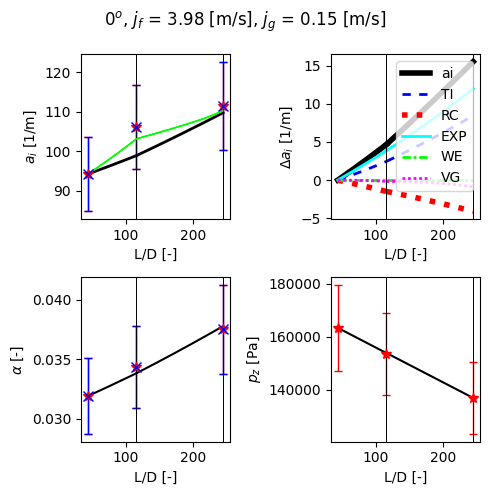

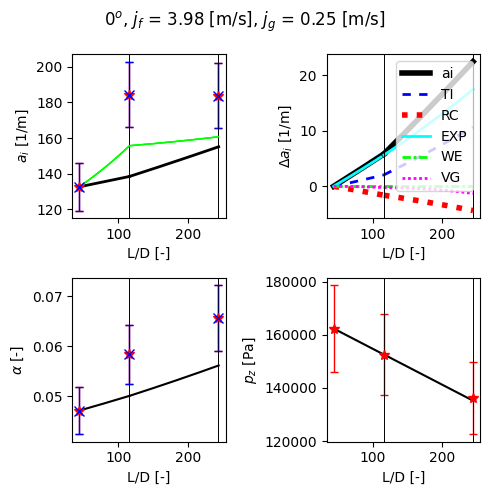

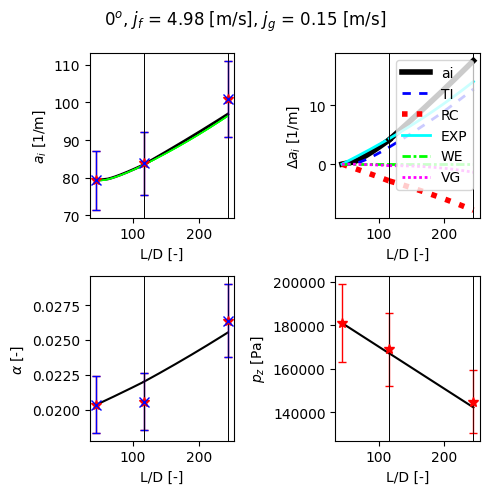

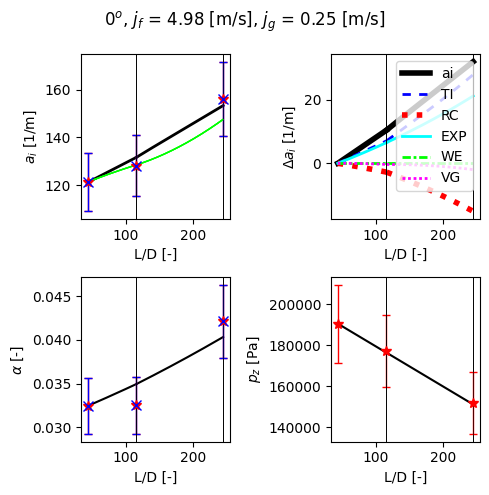

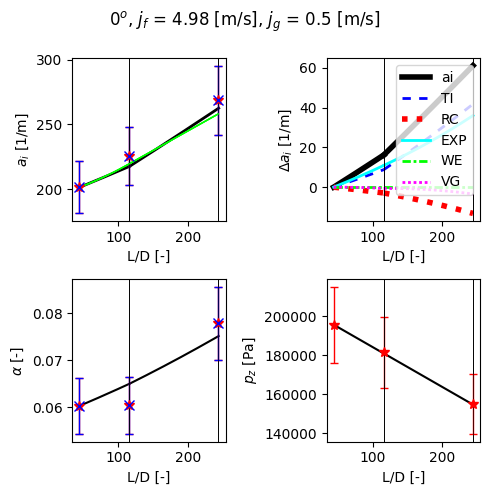

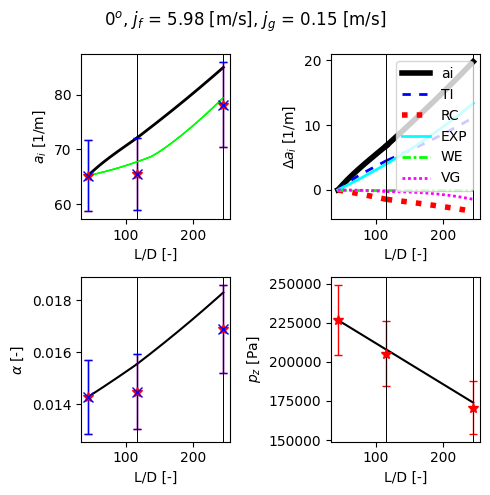

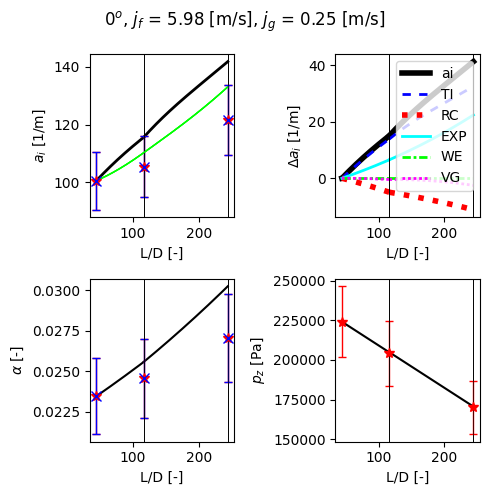

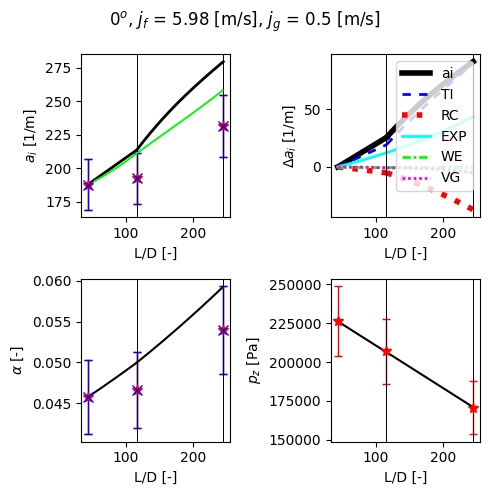

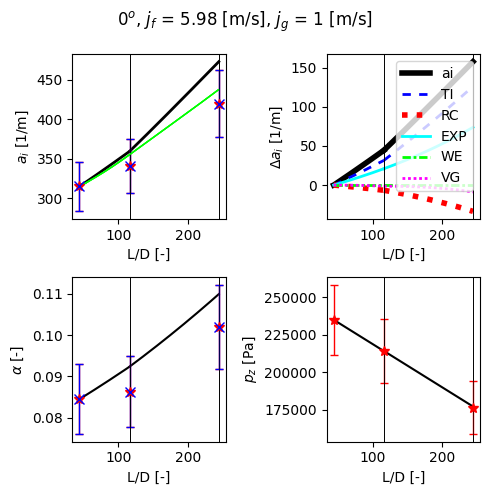

In [112]:
for i, cond in enumerate([row[0] for row in condor]):
    cond:mg.Condition

    print(cond)

    if eval(passkey):
        cond.mirror(sym90=True)

        # Plot indexing
        # p_idx = int(np.where((umap == cmap[i]).all(axis=1))[0].item())
        p_idx = i
        plt.figure(p_idx,figsize=(5,5))
        plt.suptitle("${}^o$, $j_f$ = {} [m/s], $j_g$ = {} [m/s]".format(int(cond.theta),cond.jf,cond.jgref))

        ai_st = 0
        if cond.LoverD == sp:
            for ii, cp in enumerate(endpoints):

                if ii == 0:
                    io = mg.iate_1d_1g(
                        cond, query = cp, z_step = z_step, We_cr = 5,
                        restriction = modes[ii], debug = debug, preset = preset,
                        cond2 = condor[i][ii+1]
                        )
                
                    label_ai = 'ai'
                    label_ti = 'TI'
                    label_rc = 'RC'
                    label_exp = 'EXP'
                    label_we = 'WE'
                    label_vg = 'VG'

                else:
                    io = mg.iate_1d_1g(
                        cond, query = cp, z_step = z_step, io = io, We_cr = 5,
                        restriction = modes[ii], debug = debug, preset = preset,
                        cond2 = condor[i][ii+1]
                        )
                    
                    label_ai = None
                    label_ti = None
                    label_rc = None
                    label_exp = None
                    label_we = None
                    label_vg = None
                
                print(condor[i][ii])
                
                z_mesh  = io["z_mesh"]
                ai      = io["ai"]
                aiti    = io["aiti"]
                airc    = io["airc"]
                aiexp   = io["aiexp"]
                aiwe    = io["aiwe"]
                aivg    = io["aivg"]
                alpha   = io["alpha"]
                pz      = io["pz"]

                z_mesh = z_mesh / cond.Dh

                if multiplot:
                    plt.figure(p_idx)
                    plt.subplot(221)
                    plt.plot(z_mesh,ai,'k',linewidth=2)
                    plt.ylabel('$a_i$ [1/m]')
                    plt.xlabel('L/D [-]')

                    plt.figure(p_idx)
                    plt.subplot(222)
                    plt.plot(z_mesh,ai-ai[0]+ai_st,'k',linewidth=4,label=label_ai)
                    plt.plot(z_mesh,aiti,'b',linestyle=(0,(3,3)),linewidth=2,label=label_ti)
                    plt.plot(z_mesh,-airc,'r',linestyle='dotted',linewidth=4,label=label_rc)
                    plt.plot(z_mesh,aiexp,'aqua',linewidth=2,label=label_exp)
                    plt.plot(z_mesh,-aiwe,'lime',linestyle=(0,(3,1,1,1)),linewidth=2,label=label_we)
                    plt.plot(z_mesh,-aivg,'magenta',linestyle=(0,(1,1)),linewidth=2,label=label_vg)
                    plt.legend(loc='upper right')
                    plt.ylabel(r'$\Delta$$a_i$ [1/m]')
                    plt.xlabel('L/D [-]')
                    # plt.ylim(bottom = -10, top = 60)

                    plt.figure(p_idx)
                    plt.subplot(223)
                    plt.plot(z_mesh,alpha,'k')
                    plt.ylabel(r'$\alpha$ [-]')
                    plt.xlabel('L/D [-]')

                    plt.figure(p_idx)
                    plt.subplot(224)
                    plt.plot(z_mesh,pz,'k')
                    plt.ylabel('$p_{z}$ [Pa]')
                    plt.xlabel('L/D [-]')
                    
                else:
                    plt.figure(p_idx)
                    plt.plot(z_mesh,ai,'k',linewidth=4)
                    plt.ylabel('$a_i$ [1/m]')
                    plt.xlabel('L/D [-]')

                    # plt.figure(p_idx)
                    # plt.plot(z_mesh,ai-ai[0]+ai_st,'k',linewidth=4,label=label_ai)
                    # plt.plot(z_mesh,aiti,'b',linestyle=(0,(3,3)),linewidth=2,label=label_ti)
                    # plt.plot(z_mesh,-airc,'r',linestyle='dotted',linewidth=4,label=label_rc)
                    # plt.plot(z_mesh,aiexp,'aqua',linewidth=2,label=label_exp)
                    # plt.plot(z_mesh,-aiwe,'lime',linestyle=(0,(3,1,1,1)),linewidth=2,label=label_we)
                    # plt.plot(z_mesh,-aivg,'magenta',linestyle=(0,(1,1)),linewidth=2,label=label_vg)
                    # plt.legend(loc='upper right')
                    # plt.ylabel(r'$\Delta$$a_i$ [1/m]')
                    # plt.xlabel('L/D [-]')
                    # plt.xlim(left = 20, right = 120)
                    # plt.ylim(bottom = -10, top = 60)

                ai_st = ai_st + ai[-1] - ai[0]

for i, row in enumerate([row for row in condor]):
    for ii, cond in enumerate([col for col in row]):
        cond:mg.Condition
        
        if eval(passkey):
            p_idx = i

            perr = 0.1

            if multiplot:
                plt.figure(p_idx)
                plt.subplot(221)
                plt.errorbar(cond.LoverD,cond.area_avg('ai',method='legacy'),cond.area_avg('ai',method='legacy')*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3,label='exp')

                if xl_compare == True and cond.area_avg_ai_sheet != '#REF!':
                    plt.figure(p_idx)
                    plt.subplot(221)
                    plt.errorbar(cond.LoverD,cond.area_avg_ai_sheet,cond.area_avg_ai_sheet*perr,fmt='bx',markersize=7,elinewidth=1,capsize=3,label='exp')

                plt.figure(p_idx)
                plt.subplot(222)

                plt.figure(p_idx)
                plt.subplot(223)
                plt.errorbar(cond.LoverD,cond.area_avg('alpha',method='legacy'),cond.area_avg('alpha',method='legacy')*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3)

                if xl_compare == True and cond.area_avg_void_sheet != '#REF!':
                    plt.figure(p_idx)
                    plt.subplot(223)
                    plt.errorbar(cond.LoverD,cond.area_avg_void_sheet,cond.area_avg_void_sheet*perr,fmt='bx',markersize=7,elinewidth=1,capsize=3)

                p = (cond.jgatm * 101325 / cond.jgloc)

                plt.figure(p_idx)
                plt.subplot(224)
                plt.errorbar(cond.LoverD,p,p*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3)

                for iii, cp in enumerate(endpoints):
                    plt.figure(p_idx)

                    plt.subplot(221)
                    plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

                    plt.subplot(222)
                    plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

                    plt.subplot(223)
                    plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

                    plt.subplot(224)
                    plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

                plt.tight_layout()
            
            else:
                plt.figure(p_idx)
                plt.errorbar(cond.LoverD,cond.area_avg('ai',method='legacy'),cond.area_avg('ai',method='legacy')*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3,label='exp')

                if xl_compare == True and cond.area_avg_ai_sheet != '#REF!':
                    plt.figure(p_idx)
                    plt.errorbar(cond.LoverD,cond.area_avg_ai_sheet,cond.area_avg_ai_sheet*perr,fmt='bx',markersize=7,elinewidth=1,capsize=3,label='exp')

                for iii, cp in enumerate(endpoints):
                    plt.figure(p_idx)
                    plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

                plt.tight_layout()
                
            #######################################################################################################################################################################
            # Compare against Excel standard
            if True:
                wb = op.load_workbook(filename="H:\TRSL-H\IATE\Legacy\Talley_Suite\H\standard_talley.xlsx", data_only=True)

                ws = wb['z']

                talley_z = []
                for row in ws.iter_rows(min_row=1,max_row=1,values_only=True):
                    for value in row:
                        talley_z.append(value)

                ws = wb['ai']
                talley_ai_run1 = []
                talley_ai_run2 = []
                talley_ai_run3 = []
                talley_ai_run4 = []
                talley_ai_run5 = []
                talley_ai_run6 = []
                talley_ai_run7 = []
                talley_ai_run8 = []
                talley_ai_run9 = []

                for row in ws.iter_rows(min_row=1,max_row=1,values_only=True):
                    for value in row:
                        talley_ai_run1.append(value)
                for row in ws.iter_rows(min_row=2,max_row=2,values_only=True):
                    for value in row:
                        talley_ai_run2.append(value)
                for row in ws.iter_rows(min_row=3,max_row=3,values_only=True):
                    for value in row:
                        talley_ai_run3.append(value)
                for row in ws.iter_rows(min_row=4,max_row=4,values_only=True):
                    for value in row:
                        talley_ai_run4.append(value)
                for row in ws.iter_rows(min_row=5,max_row=5,values_only=True):
                    for value in row:
                        talley_ai_run5.append(value)
                for row in ws.iter_rows(min_row=6,max_row=6,values_only=True):
                    for value in row:
                        talley_ai_run6.append(value)
                for row in ws.iter_rows(min_row=7,max_row=7,values_only=True):
                    for value in row:
                        talley_ai_run7.append(value)
                for row in ws.iter_rows(min_row=8,max_row=8,values_only=True):
                    for value in row:
                        talley_ai_run8.append(value)
                for row in ws.iter_rows(min_row=9,max_row=9,values_only=True):
                    for value in row:
                        talley_ai_run9.append(value)

                plt.figure(p_idx)

                ls = '-' #'dotted'#(0,(3,5))
                lw = 1
                lc = 'lime'

                if multiplot:
                    plt.subplot(221)

                if cond.jf == 3.98 and cond.jgatm == 0.15:
                    plt.plot(talley_z,talley_ai_run1,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 300)
                elif cond.jf == 3.98 and cond.jgref == 0.25:
                    plt.plot(talley_z,talley_ai_run2,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 200)
                elif cond.jf == 4.98 and cond.jgref == 0.15:
                    plt.plot(talley_z,talley_ai_run3,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 200)
                elif cond.jf == 4.98 and cond.jgref == 0.25:
                    plt.plot(talley_z,talley_ai_run4,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 300)
                elif cond.jf == 4.98 and cond.jgref == 0.50:
                    plt.plot(talley_z,talley_ai_run5,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 200)
                elif cond.jf == 5.98 and cond.jgref == 0.15:
                    plt.plot(talley_z,talley_ai_run6,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 600)
                elif cond.jf == 5.98 and cond.jgref == 0.25:
                    plt.plot(talley_z,talley_ai_run7,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 300)
                elif cond.jf == 5.98 and cond.jgref == 0.50:
                    plt.plot(talley_z,talley_ai_run8,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 400)
                elif cond.jf == 5.98 and cond.jgref == 1.00:
                    plt.plot(talley_z,talley_ai_run9,lc,linestyle=ls,linewidth=lw)

                    if not multiplot:
                        plt.xlim(left = 31.5789, right = 157.8947)
                        plt.ylim(bottom = 0, top = 400)

In [87]:
# for i, cond in enumerate(database):
#     cond:mg.Condition

#     print(cond)

#     if cond.jf == 3.98 and cond.jgref == 0.15:
#         cond.mirror(sym90=True)

#         # Plot indexing
#         p_idx = int(np.where((umap == cmap[i]).all(axis=1))[0].item())
#         plt.figure(p_idx,figsize=(5,5))
#         plt.suptitle("${}^o$, $j_f$ = {} [m/s], $j_g$ = {} [m/s]".format(int(cond.theta),cond.jf,cond.jgref))

#         ai_st = 0
#         if cond.LoverD == sp:
#             for ii, cp in enumerate(endpoints):

#                 if ii == 0:
#                     io = mg.iate_1d_1g(
#                         cond, query = cp, z_step = z_step, We_cr = 5,
#                         restriction = modes[ii], debug = debug, preset = preset
#                         )
                
#                     label_ai = 'ai'
#                     label_ti = 'TI'
#                     label_rc = 'RC'
#                     label_exp = 'EXP'
#                     label_we = 'WE'
#                     label_vg = 'VG'
#                 else:
#                     io = mg.iate_1d_1g(
#                         cond, query = cp, z_step = z_step, io = io, We_cr = 5,
#                         restriction = modes[ii], debug = debug, preset = preset
#                         )
                    
#                     label_ai = None
#                     label_ti = None
#                     label_rc = None
#                     label_exp = None
#                     label_we = None
#                     label_vg = None
                
#                 z_mesh  = io["z_mesh"]
#                 ai      = io["ai"]
#                 aiti    = io["aiti"]
#                 airc    = io["airc"]
#                 aiexp   = io["aiexp"]
#                 aiwe    = io["aiwe"]
#                 aivg    = io["aivg"]
#                 alpha   = io["alpha"]
#                 pz      = io["pz"]

#                 z_mesh = z_mesh / cond.Dh

#                 if multiplot:
#                     plt.figure(p_idx)
#                     plt.subplot(221)
#                     plt.plot(z_mesh,ai,'k',linewidth=2)
#                     plt.ylabel('$a_i$ [1/m]')
#                     plt.xlabel('L/D [-]')

#                     plt.figure(p_idx)
#                     plt.subplot(222)
#                     plt.plot(z_mesh,ai-ai[0]+ai_st,'k',linewidth=4,label=label_ai)
#                     plt.plot(z_mesh,aiti,'b',linestyle=(0,(3,3)),linewidth=2,label=label_ti)
#                     plt.plot(z_mesh,-airc,'r',linestyle='dotted',linewidth=4,label=label_rc)
#                     plt.plot(z_mesh,aiexp,'aqua',linewidth=2,label=label_exp)
#                     plt.plot(z_mesh,-aiwe,'lime',linestyle=(0,(3,1,1,1)),linewidth=2,label=label_we)
#                     plt.plot(z_mesh,-aivg,'magenta',linestyle=(0,(1,1)),linewidth=2,label=label_vg)
#                     plt.legend(loc='upper right')
#                     plt.ylabel(r'$\Delta$$a_i$ [1/m]')
#                     plt.xlabel('L/D [-]')
#                     # plt.ylim(bottom = -10, top = 60)

#                     plt.figure(p_idx)
#                     plt.subplot(223)
#                     plt.plot(z_mesh,alpha,'k')
#                     plt.ylabel(r'$\alpha$ [-]')
#                     plt.xlabel('L/D [-]')

#                     plt.figure(p_idx)
#                     plt.subplot(224)
#                     plt.plot(z_mesh,pz,'k')
#                     plt.ylabel('$p_{z}$ [Pa]')
#                     plt.xlabel('L/D [-]')
                    
#                 else:
#                     plt.figure(p_idx)
#                     plt.plot(z_mesh,ai,'k',linewidth=4)
#                     plt.ylabel('$a_i$ [1/m]')
#                     plt.xlabel('L/D [-]')

#                     # plt.figure(p_idx)
#                     # plt.plot(z_mesh,ai-ai[0]+ai_st,'k',linewidth=4,label=label_ai)
#                     # plt.plot(z_mesh,aiti,'b',linestyle=(0,(3,3)),linewidth=2,label=label_ti)
#                     # plt.plot(z_mesh,-airc,'r',linestyle='dotted',linewidth=4,label=label_rc)
#                     # plt.plot(z_mesh,aiexp,'aqua',linewidth=2,label=label_exp)
#                     # plt.plot(z_mesh,-aiwe,'lime',linestyle=(0,(3,1,1,1)),linewidth=2,label=label_we)
#                     # plt.plot(z_mesh,-aivg,'magenta',linestyle=(0,(1,1)),linewidth=2,label=label_vg)
#                     # plt.legend(loc='upper right')
#                     # plt.ylabel(r'$\Delta$$a_i$ [1/m]')
#                     # plt.xlabel('L/D [-]')
#                     # plt.xlim(left = 20, right = 120)
#                     # plt.ylim(bottom = -10, top = 60)

#                 ai_st = ai_st + ai[-1] - ai[0]

#         perr = 0.1

#         if multiplot:
#             plt.figure(p_idx)
#             plt.subplot(221)
#             plt.errorbar(cond.LoverD,cond.area_avg('ai',method='legacy'),cond.area_avg('ai',method='legacy')*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3,label='exp')

#             if xl_compare == True and cond.area_avg_ai_sheet != '#REF!':
#                 plt.figure(p_idx)
#                 plt.subplot(221)
#                 plt.errorbar(cond.LoverD,cond.area_avg_ai_sheet,cond.area_avg_ai_sheet*perr,fmt='bx',markersize=7,elinewidth=1,capsize=3,label='exp')

#             plt.figure(p_idx)
#             plt.subplot(222)

#             plt.figure(p_idx)
#             plt.subplot(223)
#             plt.errorbar(cond.LoverD,cond.area_avg('alpha',method='legacy'),cond.area_avg('alpha',method='legacy')*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3)

#             if xl_compare == True and cond.area_avg_void_sheet != '#REF!':
#                 plt.figure(p_idx)
#                 plt.subplot(223)
#                 plt.errorbar(cond.LoverD,cond.area_avg_void_sheet,cond.area_avg_void_sheet*perr,fmt='bx',markersize=7,elinewidth=1,capsize=3)

#             p = (cond.jgatm * 101325 / cond.jgloc)

#             plt.figure(p_idx)
#             plt.subplot(224)
#             plt.errorbar(cond.LoverD,p,p*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3)

#             for iii, cp in enumerate(endpoints):
#                 plt.figure(p_idx)

#                 plt.subplot(221)
#                 plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

#                 plt.subplot(222)
#                 plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

#                 plt.subplot(223)
#                 plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

#                 plt.subplot(224)
#                 plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

#             plt.tight_layout()
        
#         else:
#             plt.figure(p_idx)
#             plt.errorbar(cond.LoverD,cond.area_avg('ai',method='legacy'),cond.area_avg('ai',method='legacy')*perr,fmt='r*',markersize=7,elinewidth=1,capsize=3,label='exp')

#             if xl_compare == True and cond.area_avg_ai_sheet != '#REF!':
#                 plt.figure(p_idx)
#                 plt.errorbar(cond.LoverD,cond.area_avg_ai_sheet,cond.area_avg_ai_sheet*perr,fmt='bx',markersize=7,elinewidth=1,capsize=3,label='exp')

#             for iii, cp in enumerate(endpoints):
#                 plt.figure(p_idx)
#                 plt.axvline(x=endpoints[iii],linestyle='-',linewidth=0.5,c='k')

#             plt.tight_layout()
            
#         #######################################################################################################################################################################
#         # Compare against Excel standard
#         if True:
#             wb = op.load_workbook(filename="H:\TRSL-H\IATE\Legacy\Talley_Suite\H\standard_talley.xlsx", data_only=True)

#             ws = wb['z']

#             talley_z = []
#             for row in ws.iter_rows(min_row=1,max_row=1,values_only=True):
#                 for value in row:
#                     talley_z.append(value)

#             ws = wb['ai']
#             talley_ai_run1 = []
#             talley_ai_run2 = []
#             talley_ai_run3 = []
#             talley_ai_run4 = []
#             talley_ai_run5 = []
#             talley_ai_run6 = []
#             talley_ai_run7 = []
#             talley_ai_run8 = []
#             talley_ai_run9 = []

#             for row in ws.iter_rows(min_row=1,max_row=1,values_only=True):
#                 for value in row:
#                     talley_ai_run1.append(value)
#             for row in ws.iter_rows(min_row=2,max_row=2,values_only=True):
#                 for value in row:
#                     talley_ai_run2.append(value)
#             for row in ws.iter_rows(min_row=3,max_row=3,values_only=True):
#                 for value in row:
#                     talley_ai_run3.append(value)
#             for row in ws.iter_rows(min_row=4,max_row=4,values_only=True):
#                 for value in row:
#                     talley_ai_run4.append(value)
#             for row in ws.iter_rows(min_row=5,max_row=5,values_only=True):
#                 for value in row:
#                     talley_ai_run5.append(value)
#             for row in ws.iter_rows(min_row=6,max_row=6,values_only=True):
#                 for value in row:
#                     talley_ai_run6.append(value)
#             for row in ws.iter_rows(min_row=7,max_row=7,values_only=True):
#                 for value in row:
#                     talley_ai_run7.append(value)
#             for row in ws.iter_rows(min_row=8,max_row=8,values_only=True):
#                 for value in row:
#                     talley_ai_run8.append(value)
#             for row in ws.iter_rows(min_row=9,max_row=9,values_only=True):
#                 for value in row:
#                     talley_ai_run9.append(value)

#             plt.figure(p_idx)

#             ls = '-' #'dotted'#(0,(3,5))
#             lw = 1
#             lc = 'lime'

#             if multiplot:
#                 plt.subplot(221)

#             if cond.jf == 3.98 and cond.jgatm == 0.15:
#                 plt.plot(talley_z,talley_ai_run1,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 300)
#             elif cond.jf == 3.98 and cond.jgref == 0.25:
#                 plt.plot(talley_z,talley_ai_run2,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 200)
#             elif cond.jf == 4.98 and cond.jgref == 0.15:
#                 plt.plot(talley_z,talley_ai_run3,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 200)
#             elif cond.jf == 4.98 and cond.jgref == 0.25:
#                 plt.plot(talley_z,talley_ai_run4,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 300)
#             elif cond.jf == 4.98 and cond.jgref == 0.50:
#                 plt.plot(talley_z,talley_ai_run5,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 200)
#             elif cond.jf == 5.98 and cond.jgref == 0.15:
#                 plt.plot(talley_z,talley_ai_run6,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 600)
#             elif cond.jf == 5.98 and cond.jgref == 0.25:
#                 plt.plot(talley_z,talley_ai_run7,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 300)
#             elif cond.jf == 5.98 and cond.jgref == 0.50:
#                 plt.plot(talley_z,talley_ai_run8,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 400)
#             elif cond.jf == 5.98 and cond.jgref == 1.00:
#                 plt.plot(talley_z,talley_ai_run9,lc,linestyle=ls,linewidth=lw)

#                 if not multiplot:
#                     plt.xlim(left = 31.5789, right = 157.8947)
#                     plt.ylim(bottom = 0, top = 400)

In [88]:
# for cond in database:
#     cond:mg.Condition

#     if cond.jf == 3.98 and cond.jgref == 0.25 and cond.LoverD == 44:
#         print(cond)
#         # cond.mirror(sym90=True)

#         # cond.calc_COV_RC(reconstruct_flag = True)
#         # cond.calc_COV_TI(reconstruct_flag = True)

#         cond.pretty_print()

In [89]:
# for cond in database:
#     cond:mg.Condition

#     print(cond)
#     cond.mirror(sym90=True)

#     cond.calc_COV_RC(reconstruct_flag = True)
#     cond.calc_COV_TI(reconstruct_flag = True)

#     if cond.LoverD == 244:
#         print(f"error: {cond.calc_errors('alpha','alpha_reconstructed')}")
#         cond.plot_contour(param = 'alpha', num_levels = 100, colormap = 'jet', cartesian = False)
#         cond.plot_contour(param = 'alpha_reconstructed', num_levels = 100, colormap = 'jet', cartesian = False)
#         cond.plot_profiles2(param = 'alpha_reconstructed')